In [1]:
import numpy as np
from sklearn.cluster import DBSCAN

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
from osgeo import gdal, gdal_array

In [4]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.decomposition import PCA
import math as m

In [6]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [7]:
import pickle

Actually channel 2 is blue, not green. See https://github.com/apburnes/landsat8:
1 = violet; 2 = blue; 3 = green; 4 = red; 5 = NIR; 6 = midIR; 7 = far-ishIR... 10 = thermIR1, 11 = thermIR2

So the LANDSAT USGS ARD tiles are 2D 5000x5000 rasters. Location info is solely in the metadata and must include a starting point, resolution, and messier geometry / projection info.

## Check stacked geotiff from GRASS 7.8
Should have elevation and LANDSAT 8 OLI channels 1 to 7, in that order.

In [14]:
tile = gdal.Open('HI004002landclip.tif')
arr = tile.ReadAsArray()
arr.shape

(8, 1995, 1398)

In [15]:
arr.dtype

dtype('int16')

In [16]:
arr[1,0:10,0]

array([-32768, -32768,    186,    156,    156,    265,    292,    182,
          150,    102], dtype=int16)

In [17]:
arr = arr[:,2:,:]

In [18]:
arr[1,0:10,0]

array([186, 156, 156, 265, 292, 182, 150, 102,  71,  99], dtype=int16)

In [19]:
signal = arr[1:,:,:]
signal.shape

(7, 1993, 1398)

In [20]:
data = signal.reshape(7,-1).T
data.shape

(2786214, 7)

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(data)
Xc = X[np.random.choice(X.shape[0],int(0.01*X.shape[0]), replace=False)]
Xc.shape

(27862, 7)

In [22]:
pca2 = PCA(n_components=2)
signal2 = pca2.fit_transform(Xc)
print(pca2.components_)
print(pca2.explained_variance_ratio_)

[[ 0.34778739  0.38219167  0.43774737  0.43492683  0.18927255  0.37526822
   0.41897377]
 [ 0.42990128  0.36861128  0.04575932  0.10828987 -0.66990986 -0.43762798
  -0.15872158]]
[0.69088986 0.22661222]


In [23]:
pca3 = PCA(n_components=3)
signal3 = pca3.fit_transform(Xc)
print(pca3.components_)
print(pca3.explained_variance_ratio_)

[[ 0.34778739  0.38219167  0.43774737  0.43492683  0.18927255  0.37526822
   0.41897377]
 [ 0.42990128  0.36861128  0.04575932  0.10828987 -0.66990986 -0.43762798
  -0.15872158]
 [-0.35850682 -0.22884996 -0.16865114  0.19577388 -0.6348808   0.26640631
   0.52752628]]
[0.69088986 0.22661222 0.06413013]


There are the three components from before.

In [24]:
signal3.shape

(27862, 3)

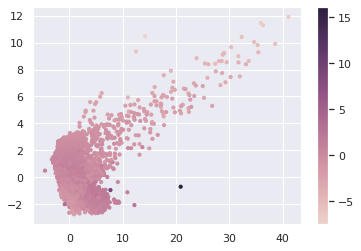

In [25]:
cmap = sns.cubehelix_palette(as_cmap=True)
# custom_palette = sns.color_palette("Oranges", 9)
f, ax = plt.subplots()
points = ax.scatter(signal3[:,0], signal3[:,1], c=signal3[:,2], s=10, cmap=cmap)
f.colorbar(points)
plt.show();

That's also a better clustering situation than in the previous workbook, isn't it? Did the palette bring something out?

Remember that I'm looking for endmembers for subpixel clustering, too.

At some point: Take the PCA results, add back elevation and/or lat/long coordinates and let the clustering look for spatial/spectral clusters, i.e. concrete regions rather than land types.

Cut off the top quarter, get rid of NODATA values at the same time as getting rid of the rest of the ocean pixels. Just focus on the land.

In [26]:
landarr = arr[:,585:,:]
landsignal = landarr[1:,:,:].copy()
landsignal[:,0,0]

array([ 581,  872, 1559, 1984, 4471, 3981, 2431], dtype=int16)

In [27]:
landsignal = landsignal.reshape(7,-1)
landsignal.shape

(7, 1968384)

In [28]:
landsignal[:,0:10]

array([[ 581,  607,  607,  657,  620,  605,  543,  368,  190,  218],
       [ 872,  929,  929,  987,  958,  945,  842,  591,  351,  381],
       [1559, 1610, 1610, 1675, 1647, 1607, 1440, 1070,  726,  889],
       [1984, 2111, 2111, 2231, 2223, 2198, 1887, 1324,  817,  980],
       [4471, 4573, 4573, 4653, 4547, 4561, 4526, 4150, 3502, 3726],
       [3981, 4222, 4222, 4366, 4316, 4291, 4011, 3142, 2168, 2444],
       [2431, 2579, 2579, 2664, 2644, 2618, 2417, 1867, 1262, 1356]],
      dtype=int16)

In [29]:
landsignal = landsignal.T
landscaler = StandardScaler()
Xl = landscaler.fit_transform(landsignal)
Xl.shape

(1968384, 7)

In [30]:
with open('landscaler.pkl','wb') as cellar:
    pickle.dump(landscaler,cellar)

In [31]:
Xs = Xl[np.random.choice(Xl.shape[0],int(0.05*Xl.shape[0]), replace=False)]
Xs.shape

(98419, 7)

In [32]:
landpca2 = PCA(n_components=2)
landsignal2 = landpca2.fit_transform(Xs)
print(landpca2.components_)
print(landpca2.explained_variance_ratio_)

[[ 0.40641648  0.41594847  0.43236949  0.4258543   0.13028371  0.34529515
   0.39662914]
 [-0.25348271 -0.23928904 -0.02455066 -0.17371456  0.79745727  0.45550451
   0.06546246]]
[0.7429977  0.18482244]


Now I've changed the components to some degree. Component 1 is brightness, but vegetation is scaled back. Component 2 has a towering vegetation component, large midIR, anti blue & violet.

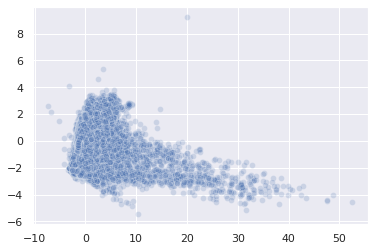

In [33]:
sns.scatterplot(x=landsignal2[:,0],y=landsignal2[:,1],alpha=0.2)
plt.show();

Boy, that still looks like a viable regression target and NOT a clustering or classification target.

In [34]:
landpca3 = PCA(n_components=3)
# note that I am changing this line to do PCA on Xl instead of the sample Xs
# because PCA is very fast and I might as well do the whole dataset
landsignal3 = landpca3.fit_transform(Xl)
print(landpca3.components_)
print(landpca3.explained_variance_ratio_)

[[ 0.40500771  0.41465021  0.43104877  0.42474744  0.12920001  0.34716781
   0.40075228]
 [-0.25596068 -0.24144226 -0.02774221 -0.17468672  0.79326565  0.45904781
   0.07006713]
 [-0.33287572 -0.25840717 -0.20855623  0.02662735 -0.49972638  0.45275378
   0.56877266]]
[0.74195274 0.18222807 0.0614415 ]


In [35]:
landsignal3.shape

(1968384, 3)

In [36]:
# pickle it and send it over to the false color map notebook
with open('landpca3.pkl','wb') as cellar:
    pickle.dump(landpca3,cellar)

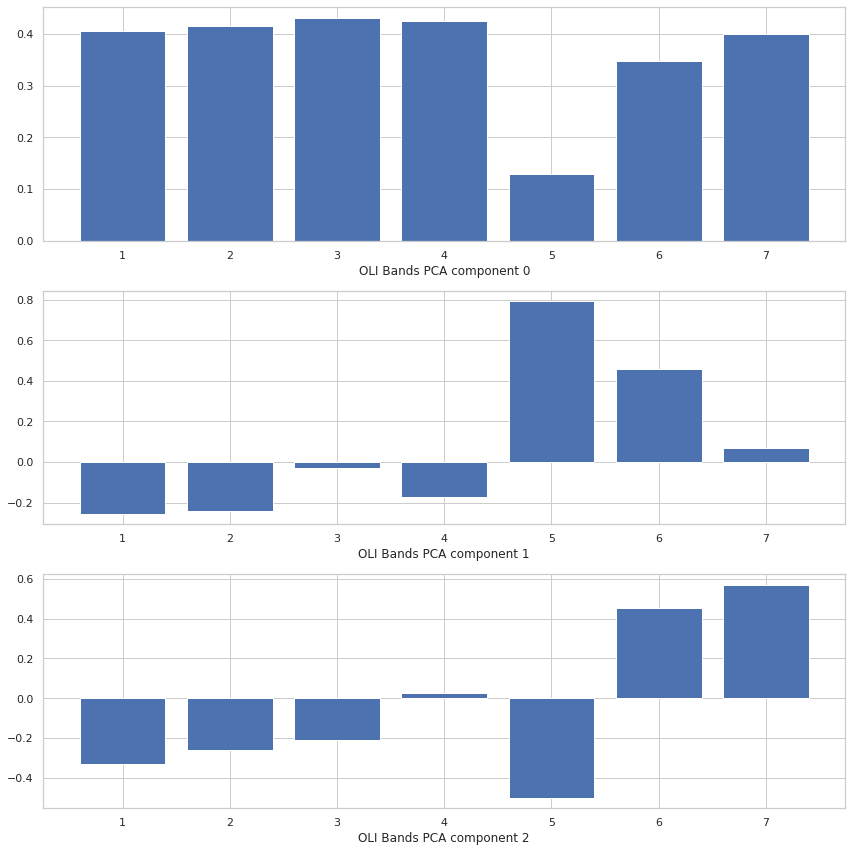

In [15]:
# for presentation: unpickle that model and plot its components
with open('landpca3.pkl','rb') as cellar:
    landpca3 = pickle.load(cellar)
sns.set_style('whitegrid')
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(12,12))
for i in range(landpca3.components_.shape[0]):
    axs[i].set_xlabel('OLI Bands PCA component '+str(i))
    # axs[i].set_ylim((-0.0,0.8))
    axs[i].bar(list(range(1,8)),landpca3.components_[i,:]);

That's a bit intriguing. It looks like we have low-vegetation brightness, vegetation, and anti-vegetation pro-rockness, perhaps.

In [37]:
samp = landsignal3[np.random.choice(landsignal3.shape[0],int(0.005*landsignal3.shape[0]), replace=False)]

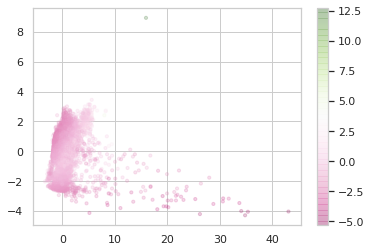

In [43]:
sns.set_style(style='whitegrid')
f, ax = plt.subplots()
points = ax.scatter(samp[:,0], samp[:,1], 
                    c=samp[:,2], s=10, cmap='PiYG', alpha=0.2)
f.colorbar(points)
plt.show();

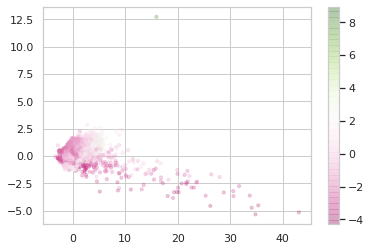

In [44]:
sns.set_style(style='whitegrid')
f, ax = plt.subplots()
points = ax.scatter(samp[:,0], samp[:,2], 
                    c=samp[:,1], s=10, cmap='PiYG', alpha=0.2)
f.colorbar(points)
plt.show();

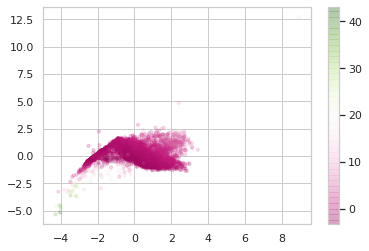

In [45]:
sns.set_style(style='whitegrid')
f, ax = plt.subplots()
points = ax.scatter(samp[:,1], samp[:,2], 
                    c=samp[:,0], s=10, cmap='PiYG', alpha=0.2)
f.colorbar(points)
plt.show();

(array([1.053000e+03, 8.785100e+05, 1.088351e+06, 2.960000e+02,
        4.300000e+01, 3.200000e+01, 3.300000e+01, 3.400000e+01,
        1.800000e+01, 1.400000e+01]),
 array([-8.40567008, -4.27345601, -0.14124194,  3.99097213,  8.1231862 ,
        12.25540026, 16.38761433, 20.5198284 , 24.65204247, 28.78425654,
        32.91647061]),
 <a list of 10 Patch objects>)

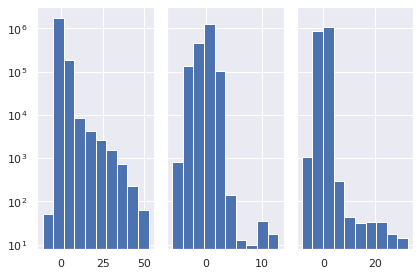

In [36]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
# We can set the number of bins with the `bins` kwarg
n_bins = 10
axs[0].hist(landsignal3[:,0], bins=n_bins, log=True)
axs[1].hist(landsignal3[:,1], bins=n_bins, log=True)
axs[2].hist(landsignal3[:,2], bins=n_bins, log=True);

In [71]:
for p in np.arange(0.10,0.60,0.025):
    signal_cluster = DBSCAN(eps=p,min_samples=25,n_jobs=2).fit(Xs)
    core_samples_mask = np.zeros_like(signal_cluster.labels_, dtype=bool)
    core_samples_mask[signal_cluster.core_sample_indices_] = True
    labels = signal_cluster.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('DBSCAN results for scaled cluster distance %0.3f' % p)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f\n" % metrics.silhouette_score(Xs, labels))

DBSCAN results for scaled cluster distance 0.100
Estimated number of clusters: 3
Estimated number of noise points: 9374
Silhouette Coefficient: -0.307

DBSCAN results for scaled cluster distance 0.125
Estimated number of clusters: 4
Estimated number of noise points: 7870
Silhouette Coefficient: -0.277

DBSCAN results for scaled cluster distance 0.150
Estimated number of clusters: 7
Estimated number of noise points: 6329
Silhouette Coefficient: -0.241

DBSCAN results for scaled cluster distance 0.175
Estimated number of clusters: 3
Estimated number of noise points: 5418
Silhouette Coefficient: 0.121

DBSCAN results for scaled cluster distance 0.200
Estimated number of clusters: 6
Estimated number of noise points: 4579
Silhouette Coefficient: -0.140

DBSCAN results for scaled cluster distance 0.225
Estimated number of clusters: 5
Estimated number of noise points: 3824
Silhouette Coefficient: 0.143

DBSCAN results for scaled cluster distance 0.250
Estimated number of clusters: 4
Estimated

I reread the clustering lecture notes and realized I should be gridsearching on n_core (number of neighbors required to nucleate a core) rather than leaving it at the default 5, although I expect that the distance is the more important hyperparameter.

In [58]:
Xss = Xl[np.random.choice(Xl.shape[0],int(0.005*Xl.shape[0]), replace=False)]
Xss.shape

(10464, 7)

In [98]:
for p in np.arange(0.30,0.60,0.05):
    for n in [5,25,125]:
        signal_cluster = DBSCAN(eps=p,min_samples=n,n_jobs=2).fit(Xs)
        core_samples_mask = np.zeros_like(signal_cluster.labels_, dtype=bool)
        core_samples_mask[signal_cluster.core_sample_indices_] = True
        labels = signal_cluster.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        print('DBSCAN results for scaled cluster distance %0.3f, core min %d' % (p,n))
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("Silhouette Coefficient: %0.3f\n" % metrics.silhouette_score(Xs, labels))

DBSCAN results for scaled cluster distance 0.300, core min 5
Estimated number of clusters: 17
Estimated number of noise points: 973
Silhouette Coefficient: -0.047

DBSCAN results for scaled cluster distance 0.300, core min 25
Estimated number of clusters: 3
Estimated number of noise points: 2351
Silhouette Coefficient: 0.228

DBSCAN results for scaled cluster distance 0.300, core min 125
Estimated number of clusters: 2
Estimated number of noise points: 4570
Silhouette Coefficient: 0.232

DBSCAN results for scaled cluster distance 0.350, core min 5
Estimated number of clusters: 8
Estimated number of noise points: 702
Silhouette Coefficient: 0.431

DBSCAN results for scaled cluster distance 0.350, core min 25
Estimated number of clusters: 4
Estimated number of noise points: 1602
Silhouette Coefficient: 0.005

DBSCAN results for scaled cluster distance 0.350, core min 125
Estimated number of clusters: 3
Estimated number of noise points: 3748
Silhouette Coefficient: 0.274

DBSCAN results f

Mean shift is also conceivably worth trying.

In [99]:
defbandwidth = estimate_bandwidth(Xs)
defbandwidth

1.750592281415471

In [100]:
for mul in np.arange(0.25,2.25,0.25):
    window = float(defbandwidth*mul)
    signal_cluster = MeanShift(bandwidth=window, bin_seeding=True,
                               cluster_all=False, n_jobs=2).fit(Xs)
    n_clusters_ = signal_cluster.cluster_centers_.shape[0]
    n_noise_ = list(signal_cluster.labels_).count(-1)
    print('Mean Shift results for window size %0.3f' % window)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    labelarray = np.concatenate((signal_cluster.labels_.reshape(-1,1),Xs),axis=1)
    clusterpoints = labelarray[labelarray[:,0]>-1]
    print("Silhouette Coefficient: %0.3f\n" % 
      metrics.silhouette_score(clusterpoints[:,1:], clusterpoints[:,0]))

Mean Shift results for window size 0.438
Estimated number of clusters: 413
Estimated number of noise points: 6105
Silhouette Coefficient: 0.413

Mean Shift results for window size 0.875
Estimated number of clusters: 109
Estimated number of noise points: 4806
Silhouette Coefficient: 0.655

Mean Shift results for window size 1.313
Estimated number of clusters: 54
Estimated number of noise points: 2966
Silhouette Coefficient: 0.599

Mean Shift results for window size 1.751
Estimated number of clusters: 24
Estimated number of noise points: 3392
Silhouette Coefficient: 0.810

Mean Shift results for window size 2.188
Estimated number of clusters: 18
Estimated number of noise points: 2338
Silhouette Coefficient: 0.763

Mean Shift results for window size 2.626
Estimated number of clusters: 12
Estimated number of noise points: 1089
Silhouette Coefficient: 0.729

Mean Shift results for window size 3.064
Estimated number of clusters: 11
Estimated number of noise points: 703
Silhouette Coefficient

Well hell. Let's go a bit further.

In [102]:
for mul in np.arange(2.25,3.25,0.25):
    window = float(defbandwidth*mul)
    signal_cluster = MeanShift(bandwidth=window, bin_seeding=True,
                               cluster_all=False, n_jobs=2).fit(Xs)
    n_clusters_ = signal_cluster.cluster_centers_.shape[0]
    n_noise_ = list(signal_cluster.labels_).count(-1)
    print('Mean Shift results for window size %0.3f' % window)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    labelarray = np.concatenate((signal_cluster.labels_.reshape(-1,1),Xs),axis=1)
    clusterpoints = labelarray[labelarray[:,0]>-1]
    print("Silhouette Coefficient: %0.3f\n" % 
      metrics.silhouette_score(clusterpoints[:,1:], clusterpoints[:,0]))

Mean Shift results for window size 3.939
Estimated number of clusters: 7
Estimated number of noise points: 418
Silhouette Coefficient: 0.700

Mean Shift results for window size 4.376
Estimated number of clusters: 6
Estimated number of noise points: 373
Silhouette Coefficient: 0.696

Mean Shift results for window size 4.814
Estimated number of clusters: 5
Estimated number of noise points: 302
Silhouette Coefficient: 0.691

Mean Shift results for window size 5.252
Estimated number of clusters: 4
Estimated number of noise points: 242
Silhouette Coefficient: 0.766



In [103]:
labelpca3 = np.concatenate((signal_cluster.labels_.reshape(-1,1),landsignal3),axis=1)

In [109]:
centroids = landpca3.transform(signal_cluster.cluster_centers_)

In [110]:
labels = (np.array(np.arange(4))).reshape(4,1)
labels

array([[0],
       [1],
       [2],
       [3]])

In [111]:
centroid_label = np.concatenate((labels,centroids),axis=1)
centroid_label

array([[ 0.00000000e+00, -2.65483939e-01,  2.05806341e-03,
        -1.58237190e-03],
       [ 1.00000000e+00,  2.43647596e+01, -2.41524704e+00,
         2.61205740e+00],
       [ 2.00000000e+00,  4.83216579e+01, -4.20991565e+00,
         6.57663750e+00],
       [ 3.00000000e+00,  3.41941141e+00,  5.42933475e+00,
        -3.54018951e+00]])

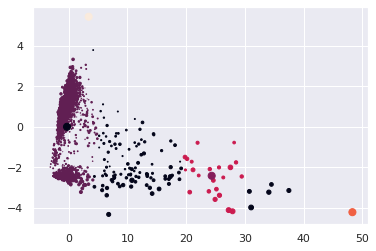

In [113]:
f, ax = plt.subplots()
points = ax.scatter(labelpca3[:,1], labelpca3[:,2], 
                    s=labelpca3[:,3]*5, c=labelpca3[:,0])
centers = ax.scatter(centroid_label[:,1], centroid_label[:,2], 
                    s=50, c=centroid_label[:,0])
plt.show();

In [114]:
sig_clusts=[]
for mul in np.arange(2.25,3.25,0.25):
    window = float(defbandwidth*mul)
    sig_clusts.append(MeanShift(bandwidth=window, bin_seeding=True,
                               cluster_all=False, n_jobs=2).fit(Xs))
    n_clusters_ = sig_clusts[-1].cluster_centers_.shape[0]
    n_noise_ = list(sig_clusts[-1].labels_).count(-1)
    print('Mean Shift results for window size %0.3f' % window)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    labelarray = np.concatenate((sig_clusts[-1].labels_.reshape(-1,1),Xs),axis=1)
    clusterpoints = labelarray[labelarray[:,0]>-1]
    print("Silhouette Coefficient: %0.3f\n" % 
      metrics.silhouette_score(clusterpoints[:,1:], clusterpoints[:,0]))

Mean Shift results for window size 3.939
Estimated number of clusters: 7
Estimated number of noise points: 418
Silhouette Coefficient: 0.700

Mean Shift results for window size 4.376
Estimated number of clusters: 6
Estimated number of noise points: 373
Silhouette Coefficient: 0.696

Mean Shift results for window size 4.814
Estimated number of clusters: 5
Estimated number of noise points: 302
Silhouette Coefficient: 0.691

Mean Shift results for window size 5.252
Estimated number of clusters: 4
Estimated number of noise points: 242
Silhouette Coefficient: 0.766



In [119]:
cents = []
for ms in sig_clusts:
    cnum = []
    cents.append(landpca3.transform(ms.cluster_centers_))
    labels = (np.array(np.arange(ms.cluster_centers_.shape[0]))).reshape(-1,1)
    for label in labels:
        cnum.append(list(ms.labels_).count(label))
    cnum = (np.array(cnum)).reshape(-1,1)
    cents[-1] = np.concatenate((labels,cents[-1],cnum),axis=1)

In [120]:
cents[2]

array([[ 0.00000000e+00, -2.91996444e-01, -5.86079051e-03,
         5.35566406e-03,  9.51900000e+03],
       [ 1.00000000e+00,  2.69426102e+01, -2.80333043e+00,
         3.01633372e+00,  1.60000000e+01],
       [ 2.00000000e+00, -3.28528997e+00,  1.17558864e+00,
        -4.07077339e+00,  2.00000000e+00],
       [ 3.00000000e+00,  4.83216579e+01, -4.20991565e+00,
         6.57663750e+00,  1.00000000e+00],
       [ 4.00000000e+00,  3.41941141e+00,  5.42933475e+00,
        -3.54018951e+00,  1.00000000e+00]])

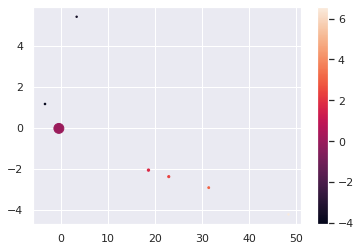

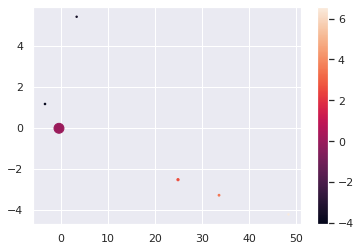

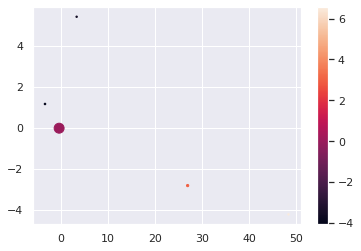

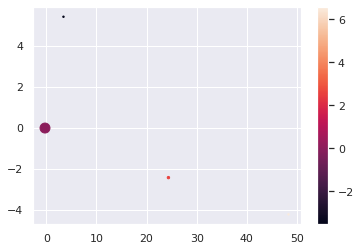

In [122]:
for centroids in cents:
    f, ax = plt.subplots()
    centers = ax.scatter(centroids[:,1], centroids[:,2], 
                        s=1+np.sqrt(centroids[:,4]), c=centroids[:,3])
    f.colorbar(centers)
    plt.show();

In [123]:
cents

[array([[ 0.00000000e+00, -3.47725425e-01, -1.55562596e-02,
          1.40683241e-02,  9.38200000e+03],
        [ 1.00000000e+00,  1.86441253e+01, -2.04876922e+00,
          1.79043639e+00,  1.90000000e+01],
        [ 2.00000000e+00,  2.29452005e+01, -2.36754997e+00,
          2.35821793e+00,  1.20000000e+01],
        [ 3.00000000e+00,  3.14133107e+01, -2.90501085e+00,
          3.08448885e+00,  6.00000000e+00],
        [ 4.00000000e+00, -3.28528997e+00,  1.17558864e+00,
         -4.07077339e+00,  2.00000000e+00],
        [ 5.00000000e+00,  4.83216579e+01, -4.20991565e+00,
          6.57663750e+00,  1.00000000e+00],
        [ 6.00000000e+00,  3.41941141e+00,  5.42933475e+00,
         -3.54018951e+00,  1.00000000e+00]]),
 array([[ 0.00000000e+00, -3.23685118e-01, -1.04239735e-02,
          9.68755863e-03,  9.44300000e+03],
        [ 1.00000000e+00,  2.49037574e+01, -2.51666734e+00,
          2.64414261e+00,  1.60000000e+01],
        [ 2.00000000e+00,  3.35995758e+01, -3.27339543e+00,
  